In [1]:
import argparse
import datetime
import logging
import os
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import torch.autograd as tgrad

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

In [4]:
import utils
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Network

In [5]:
class AdaptiveLinear(nn.Linear):
    r"""Applies a linear transformation to the input data as follows
    :math:`y = naxA^T + b`.
    More details available in Jagtap, A. D. et al. Locally adaptive
    activation functions with slope recovery for deep and
    physics-informed neural networks, Proc. R. Soc. 2020.

    Parameters
    ----------
    in_features : int
        The size of each input sample
    out_features : int 
        The size of each output sample
    bias : bool, optional
        If set to ``False``, the layer will not learn an additive bias
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice 
        (self.A is the learnable parameter which is initialized by the 
        self.adaptive rate. To create a learnable parameter for each neuron, 
        it multiplies the self.adaptive rate to the number of input features.)
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, in_features, out_features, bias=True, adaptive_rate=None, adaptive_rate_scaler=None):
        super(AdaptiveLinear, self).__init__(in_features, out_features, bias)
        self.adaptive_rate = adaptive_rate
        self.adaptive_rate_scaler = adaptive_rate_scaler
        if self.adaptive_rate:
            self.A = nn.Parameter(self.adaptive_rate * torch.ones(self.in_features))
            if not self.adaptive_rate_scaler:
                self.adaptive_rate_scaler = 10.0
            
    def forward(self, input):
        if self.adaptive_rate:
            return nn.functional.linear(self.adaptive_rate_scaler * self.A * input, self.weight, self.bias)
        return nn.functional.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return (
            f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}, '
            f'adaptive_rate={self.adaptive_rate is not None}, adaptive_rate_scaler={self.adaptive_rate_scaler is not None}'
        )

class Net(nn.Module):
    r"""Neural approximator for the unknown function that is supposed
    to be solved.

    Parameters
    ----------
    sizes : list
        Each element represents the number of neuron per layer
    activation : callable 
        Activation function
    dropout_rate : float, optional
        Dropout rate for regulrization during training process and
        uncertainty quantification by means of Monte Carlo dropout
        procedure while performing evaluation
    adaptive_rate : float, optional
        Scalable adaptive rate parameter for activation function that
        is added layer-wise for each neuron separately. It is treated
        as learnable parameter and will be optimized using a optimizer
        of choice
    adaptive_rate_scaler : float, optional
        Fixed, pre-defined, scaling factor for adaptive activation
        functions
    """
    def __init__(self, sizes, activation, dropout_rate=0.0, adaptive_rate=None, adaptive_rate_scaler=None):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(
            *[
                Net.linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler)
                for in_features, out_features in zip(sizes[:-1], sizes[1:-1])
            ],
            # because the output is the price of the option, we use regular linear transformation     
            AdaptiveLinear(sizes[-2], sizes[-1]) # output layer is regular linear transformation
            )
        
    def forward(self, x):
        return self.regressor(x)

    @staticmethod
    def linear_block(in_features, out_features, activation, dropout_rate, adaptive_rate, adaptive_rate_scaler):
        activation_dispatcher = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU()],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()],
            ['sigmoid', nn.Sigmoid()],
            # ['swish', Swish()]
        ])
        return nn.Sequential(
            AdaptiveLinear(in_features, out_features, adaptive_rate=adaptive_rate, adaptive_rate_scaler=adaptive_rate_scaler),
            activation_dispatcher[activation],
            nn.Dropout(dropout_rate),
            )

In [6]:
IPINN = Net(
    sizes=[2, 50, 50, 50, 50, 50, 50, 50, 50, 1], activation='relu', dropout_rate=0, adaptive_rate=0.1, adaptive_rate_scaler=10.0
    )
IPINN.cuda()
print('done')

done


# Train

In [7]:
n_epochs = 50000
lossFunction = nn.MSELoss()
lr = 3e-5
optimizer = optim.Adam(IPINN.parameters(), lr=lr)

ipinn_loss_weight = [[1, 1, 1], [1, 2, 2], [1, 5, 5], [2, 1, 1], [5, 1, 1]]
index = 0
x_f_s = torch.tensor(-np.log(ipinn_loss_weight[index][0])).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(-np.log(ipinn_loss_weight[index][1])).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(-np.log(ipinn_loss_weight[index][2])).float().to(device).requires_grad_(True)
w_lr = 0.001
optimizer_adam_weight = optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=w_lr)

In [8]:
loss_hist = []
x_f_s_hist = []
x_label_s_hist = []
x_data_s_hist = []

min_train_loss = float("inf")  # Initialize with a large value
final_model = None
start_time = time.time()
for _ in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = IPINN(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y21_hat = IPINN(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y21_hat)
    
    # data Round
    y3_hat = IPINN(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # slope recovery term
    local_recovery_terms = torch.tensor([torch.mean(IPINN.regressor[layer][0].A.data) for layer in range(len(IPINN.regressor) - 1)])
    slope_recovery_term = 1 / torch.mean(torch.exp(local_recovery_terms))
    
    # update the neural network parameters
    optimizer.zero_grad()
    total_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + slope_recovery_term + x_f_s + x_label_s + x_data_s
    total_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + x_f_s + torch.exp(-x_label_s) * bc_loss.detach() + x_label_s + torch.exp(-x_data_s) * data_loss.detach() + x_data_s + slope_recovery_term
    loss.backward()
    optimizer_adam_weight.step()
    
    # print loss
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    x_f_s_hist.append(torch.exp(-x_f_s).item())
    x_label_s_hist.append(torch.exp(-x_label_s).item())
    x_data_s_hist.append(torch.exp(-x_data_s).item())
    if _ % 500 == 0:
        print(f'{_}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, Data Loss: {data_loss.item():.5f}, reg_loss: {slope_recovery_term.item(): 5f}, total loss: {mse_loss.item():5f}, minimum loss: {min(loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}')
    
    # save the best model
    if mse_loss.item() < min_train_loss:
        min_train_loss = mse_loss.item()
        final_model = IPINN.state_dict()
    pass
elapsed = timer() - start_time
end_time = time.time()
print('run time:', end_time - start_time)

loss_weights_hist = pd.DataFrame({
        'PDE_Weight': x_f_s_hist,
        'BC_Weight': x_label_s_hist,
        'Data_Weight': x_data_s_hist
    })
loss_weights_hist.to_csv(f'weights/ipnn_converge.csv', index=False)

0/50000 PDE Loss: 0.00004, BC Loss: 667.76440, Data Loss: 418.25104, reg_loss:  0.904837, total loss: 1086.015503, minimum loss: 1086.01550
the weight is 1.00100, 0.99900. 0.99900
500/50000 PDE Loss: 0.02198, BC Loss: 7.96836, Data Loss: 15.13414, reg_loss:  0.894055, total loss: 23.124475, minimum loss: 23.12448
the weight is 1.64852, 0.73385. 0.73395
1000/50000 PDE Loss: 0.03038, BC Loss: 0.73267, Data Loss: 1.23073, reg_loss:  0.888748, total loss: 1.993774, minimum loss: 1.99377
the weight is 2.42324, 0.73065. 0.72216
1500/50000 PDE Loss: 0.00049, BC Loss: 0.00143, Data Loss: 0.00190, reg_loss:  0.887735, total loss: 0.003821, minimum loss: 0.00359
the weight is 4.25411, 0.73231. 0.72471
2000/50000 PDE Loss: 0.00004, BC Loss: 0.00130, Data Loss: 0.00180, reg_loss:  0.887544, total loss: 0.003146, minimum loss: 0.00290
the weight is 7.25328, 0.73470. 0.72851
2500/50000 PDE Loss: 0.00005, BC Loss: 0.00219, Data Loss: 0.00276, reg_loss:  0.887436, total loss: 0.004997, minimum loss: 0

In [9]:
# Evaluate the model on the test set
IPINN.eval()
with torch.no_grad():
    test_outputs = IPINN(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0028


In [10]:
for i in range(50000):
    if i % 500 == 0:
        print(loss_hist[i])

1086.0155029296875
23.124475479125977
1.9937740564346313
0.0038210065104067326
0.0031460062600672245
0.004996784962713718
0.003744109533727169
0.004240427166223526
0.0028652723412960768
0.003017166629433632
0.003645088989287615
0.0052408091723918915
0.0036469544284045696
0.003925826400518417
0.0029475484043359756
1.2114883661270142
0.0029166778549551964
0.02010885253548622
0.0036476007662713528
0.003121150890365243
0.0032730065286159515
0.0027754323091357946
0.003672204911708832
0.005250970833003521
0.08259159326553345
0.0030601518228650093
0.0030928626656532288
0.013655642047524452
0.015385309234261513
0.0029018032364547253
0.01000036671757698
0.00445989053696394
0.018472664058208466
0.0033206213265657425
0.0039838277734816074
0.002722592558711767
0.006342163309454918
0.0200166255235672
0.0028998993802815676
0.004775278270244598
0.005885332822799683
0.00414273701608181
0.0027037207037210464
0.0027259616181254387
0.0027910727076232433
0.0028698425740003586
0.0031209797598421574
0.00316

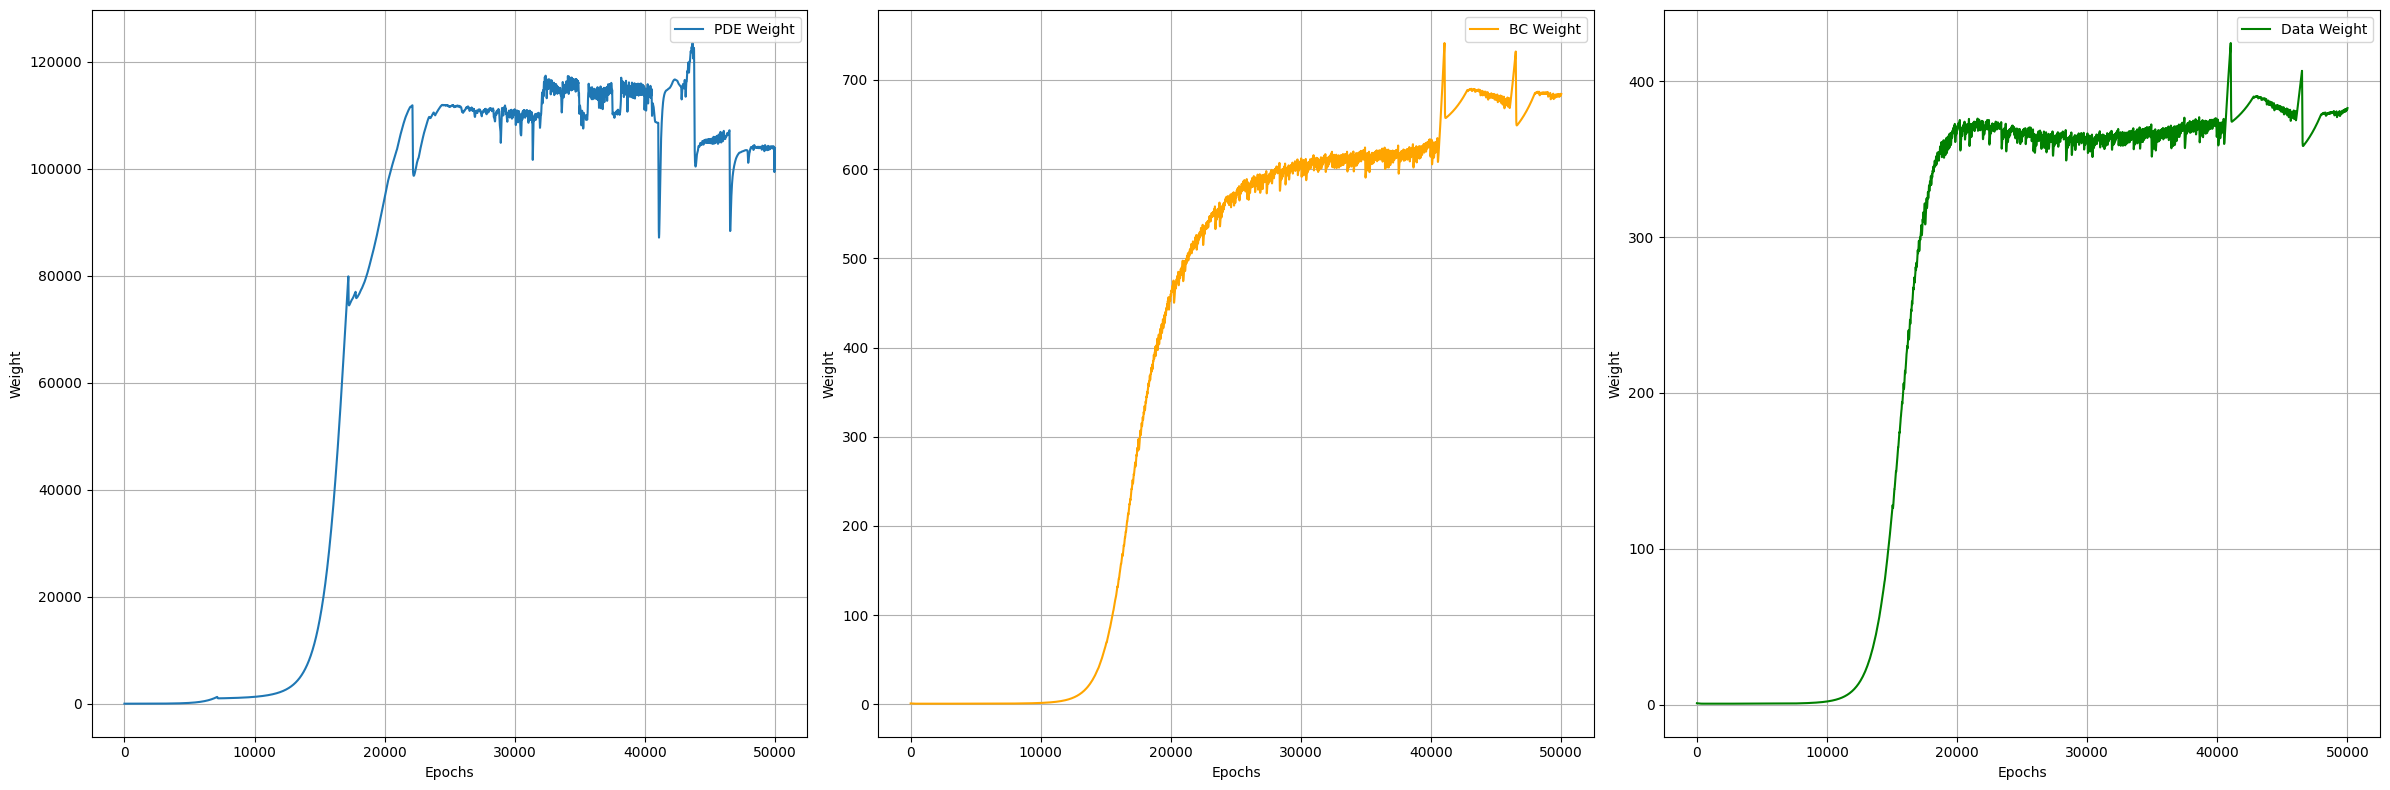

In [19]:
# Create a figure with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 'PDE Weight' in the first subplot (axes[0])
axes[0].plot(loss_weights_hist['PDE_Weight'], label='PDE Weight')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True)

# Plot 'BC Weight' in the second subplot (axes[1])
axes[1].plot(loss_weights_hist['BC_Weight'], label='BC Weight', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Weight')
axes[1].legend()
axes[1].grid(True)

# Plot 'Data Weight' in the third subplot (axes[2])
axes[2].plot(loss_weights_hist['Data_Weight'], label='Data Weight', color='green')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Weight')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # You can replace with save if needed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


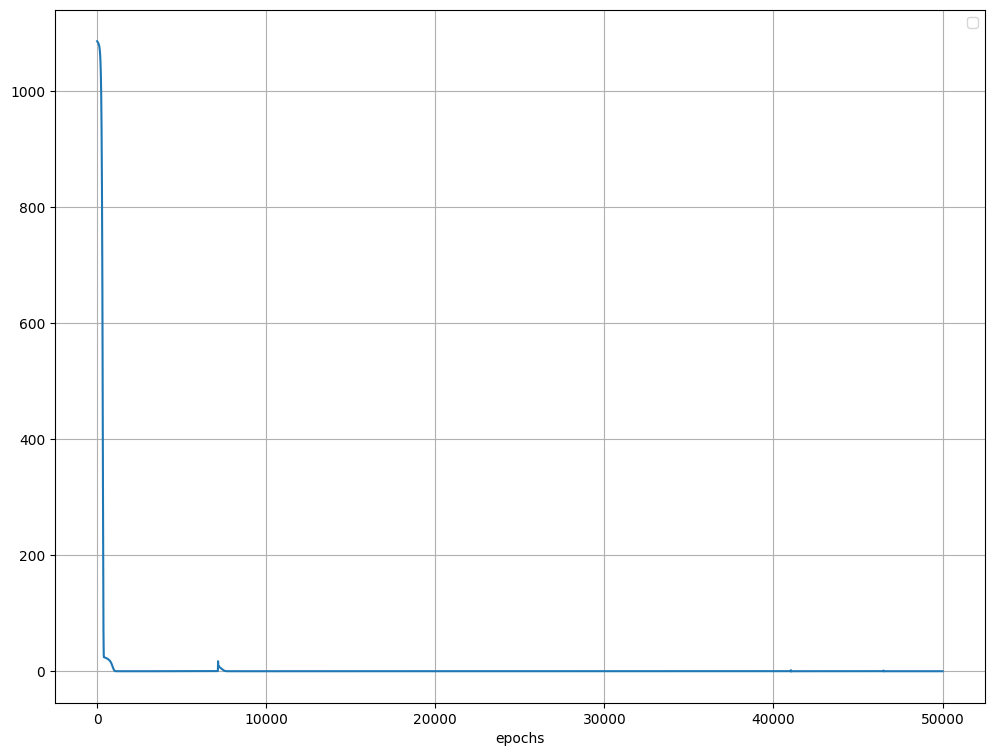

In [13]:
fig = plt.figure(figsize=(12,9))
plt.plot(loss_hist[:])
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.show()  # You can replace with save if needed